# Exoplanet Candidate Classification with Random Forest

This notebook analyzes Kepler Objects of Interest (KOI) data to build a Random Forest model for predicting exoplanet candidates vs non-candidates. The workflow follows a similar approach to the existing SVM and XGBoost models with comprehensive data exploration, feature engineering, hyperparameter optimization, and comparative analysis.

## Dataset Overview
- **Training Data**: KOI-Playground-Train-Data.csv
- **Test Data**: KOI-Playground-Test-Data.csv
- **Reference Data**: data/KOI Selected Data.csv
- **Target Variable**: koi_disposition (candidate vs non-candidate)

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_auc_score, roc_curve, 
                           precision_recall_curve, auc)
from sklearn.feature_selection import mutual_info_classif

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# SVM for comparison
from sklearn.svm import SVC

# XGBoost for comparison
import xgboost as xgb
from xgboost import XGBClassifier

# For hyperparameter tuning
from scipy.stats import randint, uniform

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# Principal Component Analysis for visualization
from sklearn.decomposition import PCA

# For model persistence
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore the Dataset

In [2]:
# Load the datasets
print("Loading datasets...")

# Load training data
train_data = pd.read_csv('KOI-Playground-Train-Data.csv')
print(f"Training data shape: {train_data.shape}")

# Note: We'll use only the training data for all phases:
# - Split it for training/validation during development
# - Use 100% for final model training after hyperparameter optimization

print("\nDataset loaded successfully!")
print("Using training data for all phases: training, validation, and final model training")

Loading datasets...
Training data shape: (7651, 20)

Dataset loaded successfully!
Using training data for all phases: training, validation, and final model training


In [3]:
# Explore the training dataset
print("=== TRAINING DATA EXPLORATION ===")
print(f"Shape: {train_data.shape}")
print(f"Columns: {list(train_data.columns)}")
print(f"\nData types:")
print(train_data.dtypes)

print(f"\nFirst few rows:")
display(train_data.head())

print(f"\nTarget variable distribution:")
print(train_data['koi_disposition'].value_counts())
print(f"\nTarget variable percentages:")
print(train_data['koi_disposition'].value_counts(normalize=True) * 100)

=== TRAINING DATA EXPLORATION ===
Shape: (7651, 20)
Columns: ['kepid', 'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_sma', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_datalink_dvr', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

Data types:
kepid                 int64
koi_disposition      object
koi_period          float64
koi_time0bk         float64
koi_time0           float64
koi_eccen           float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_sma             float64
koi_incl            float64
koi_model_snr       float64
koi_count             int64
koi_bin_oedp_sig    float64
koi_datalink_dvr     object
koi_steff           float64
koi_slogg           float64
koi_srad            float64
koi_smass           float64
koi_kepmag          float64
dtype: object

First few rows:


,kepid,koi_disposition,koi_period,koi_time0bk,koi_time0,koi_eccen,koi_impact,koi_duration,koi_depth,koi_sma,koi_incl,koi_model_snr,koi_count,koi_bin_oedp_sig,koi_datalink_dvr,koi_steff,koi_slogg,koi_srad,koi_smass,koi_kepmag
0,7870250,non-candidate,0.580725,131.72956,2454964.730,0.0,0.292,1.8200,64.2,0.0136,83.11,16.9,1,0.9930,007/007870/007870250/dv/kplr007870250-20160209...,5989.0,4.492,0.933,0.986,14.569
1,11651712,candidate,14.532605,140.46850,2454973.468,0.0,0.112,2.4212,328.9,0.1173,89.86,29.0,1,0.2915,011/011651/011651712/dv/kplr011651712-20160209...,6003.0,4.507,0.932,1.019,13.785
2,4945877,non-candidate,1.339670,132.16786,2454965.168,0.0,0.602,1.8950,28.6,0.0289,82.16,21.7,1,0.0005,004/004945/004945877/dv/kplr004945877-20160209...,8867.0,3.988,2.245,1.789,10.455
3,6289344,non-candidate,160.412202,262.40022,2455095.400,0.0,0.903,4.9200,2538.0,0.5375,89.62,24.4,1,0.0000,006/006289/006289344/dv/kplr006289344-20160209...,5269.0,4.620,0.727,0.812,15.407
4,9843517,candidate,11.937835,133.26120,2454966.261,0.0,0.036,4.6520,246.0,0.0954,89.90,9.6,1,0.9246,009/009843/009843517/dv/kplr009843517-20160209...,5469.0,4.611,0.738,0.826,15.954



Target variable distribution:
koi_disposition
non-candidate    3900
candidate        3751
Name: count, dtype: int64

Target variable percentages:
koi_disposition
non-candidate    50.973729
candidate        49.026271
Name: proportion, dtype: float64


In [4]:
# Check for missing values
print("=== MISSING VALUES ANALYSIS ===")
missing_train = train_data.isnull().sum()
missing_percent_train = (missing_train / len(train_data)) * 100

# Create summary DataFrame for training data
missing_summary = pd.DataFrame({
    'Column': train_data.columns,
    'Train_Missing': missing_train.values,
    'Train_Missing_%': missing_percent_train.values
})

missing_summary = missing_summary[missing_summary['Train_Missing'] > 0].sort_values('Train_Missing_%', ascending=False)
print("Columns with missing values in training data:")
display(missing_summary)

=== MISSING VALUES ANALYSIS ===
Columns with missing values in training data:


,Column,Train_Missing,Train_Missing_%
13,koi_bin_oedp_sig,1226,16.024049
10,koi_incl,288,3.764214
5,koi_eccen,287,3.751144
8,koi_depth,287,3.751144
6,koi_impact,287,3.751144
9,koi_sma,287,3.751144
11,koi_model_snr,287,3.751144
15,koi_steff,287,3.751144
16,koi_slogg,287,3.751144
18,koi_smass,287,3.751144


## 3. Data Preprocessing and Cleaning

In [5]:
# Create working copy of the data
train_df = train_data.copy()

print("=== DATA PREPROCESSING ===")

# Remove columns that are not useful for modeling
columns_to_drop = ['kepid', 'koi_datalink_dvr']  # ID columns and URLs
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')

print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {len(train_df.columns)}")

# Handle missing values
print(f"\nHandling missing values...")

# For numerical features, fill missing values with median
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
numerical_cols = numerical_cols.drop('koi_disposition', errors='ignore')

for col in numerical_cols:
    if train_df[col].isnull().sum() > 0:
        median_val = train_df[col].median()
        train_df[col].fillna(median_val, inplace=True)
        print(f"Filled {col} with median: {median_val}")

print(f"\nMissing values after preprocessing:")
print(f"Train: {train_df.isnull().sum().sum()}")

=== DATA PREPROCESSING ===
Dropped columns: ['kepid', 'koi_datalink_dvr']
Remaining columns: 18

Handling missing values...
Filled koi_eccen with median: 0.0
Filled koi_impact with median: 0.5356
Filled koi_depth with median: 425.95
Filled koi_sma with median: 0.0858
Filled koi_incl with median: 88.52
Filled koi_model_snr with median: 23.2
Filled koi_bin_oedp_sig with median: 0.4776
Filled koi_steff with median: 5767.0
Filled koi_slogg with median: 4.438
Filled koi_srad with median: 1.0
Filled koi_smass with median: 0.975
Filled koi_kepmag with median: 14.523

Missing values after preprocessing:
Train: 0


In [6]:
# Convert target variable to binary
print("=== TARGET VARIABLE PREPROCESSING ===")
print(f"Original target distribution:\n{train_df['koi_disposition'].value_counts()}")

# Create binary target: 1 for candidate, 0 for non-candidate
le = LabelEncoder()
train_df['target'] = le.fit_transform(train_df['koi_disposition'])

print(f"\nEncoded target distribution:")
print(f"Training: {pd.Series(train_df['target']).value_counts()}")

# Map target values
target_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"\nTarget mapping: {target_mapping}")

# Remove original disposition column
train_df = train_df.drop('koi_disposition', axis=1)

=== TARGET VARIABLE PREPROCESSING ===
Original target distribution:
koi_disposition
non-candidate    3900
candidate        3751
Name: count, dtype: int64

Encoded target distribution:
Training: target
1    3900
0    3751
Name: count, dtype: int64

Target mapping: {'candidate': np.int64(0), 'non-candidate': np.int64(1)}


## 4. Exploratory Data Analysis and Visualizations

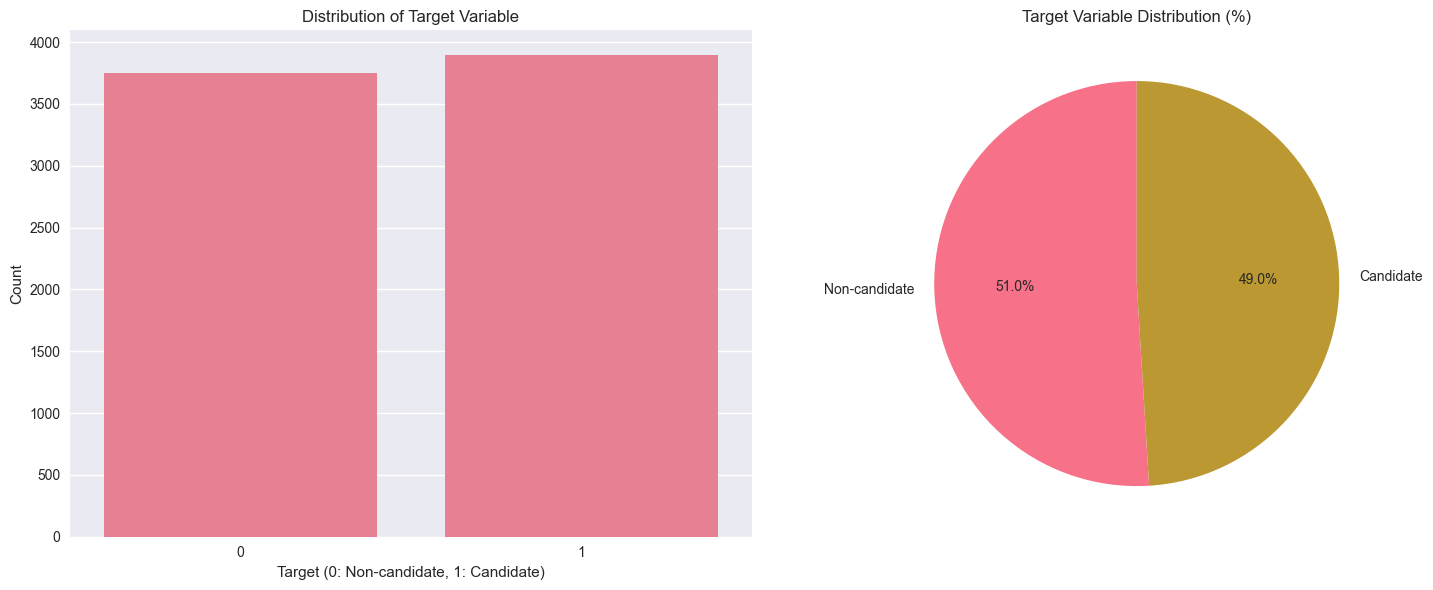

Class distribution:
Non-candidates: 3751 (49.0%)
Candidates: 3900 (51.0%)


In [7]:
# Target variable distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
sns.countplot(data=train_df, x='target', ax=ax1)
ax1.set_title('Distribution of Target Variable')
ax1.set_xlabel('Target (0: Non-candidate, 1: Candidate)')
ax1.set_ylabel('Count')

# Pie chart
target_counts = train_df['target'].value_counts()
labels = ['Non-candidate', 'Candidate']
ax2.pie(target_counts.values, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Target Variable Distribution (%)')

plt.tight_layout()
plt.show()

print(f"Class distribution:")
print(f"Non-candidates: {target_counts[0]} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"Candidates: {target_counts[1]} ({target_counts[1]/len(train_df)*100:.1f}%)")

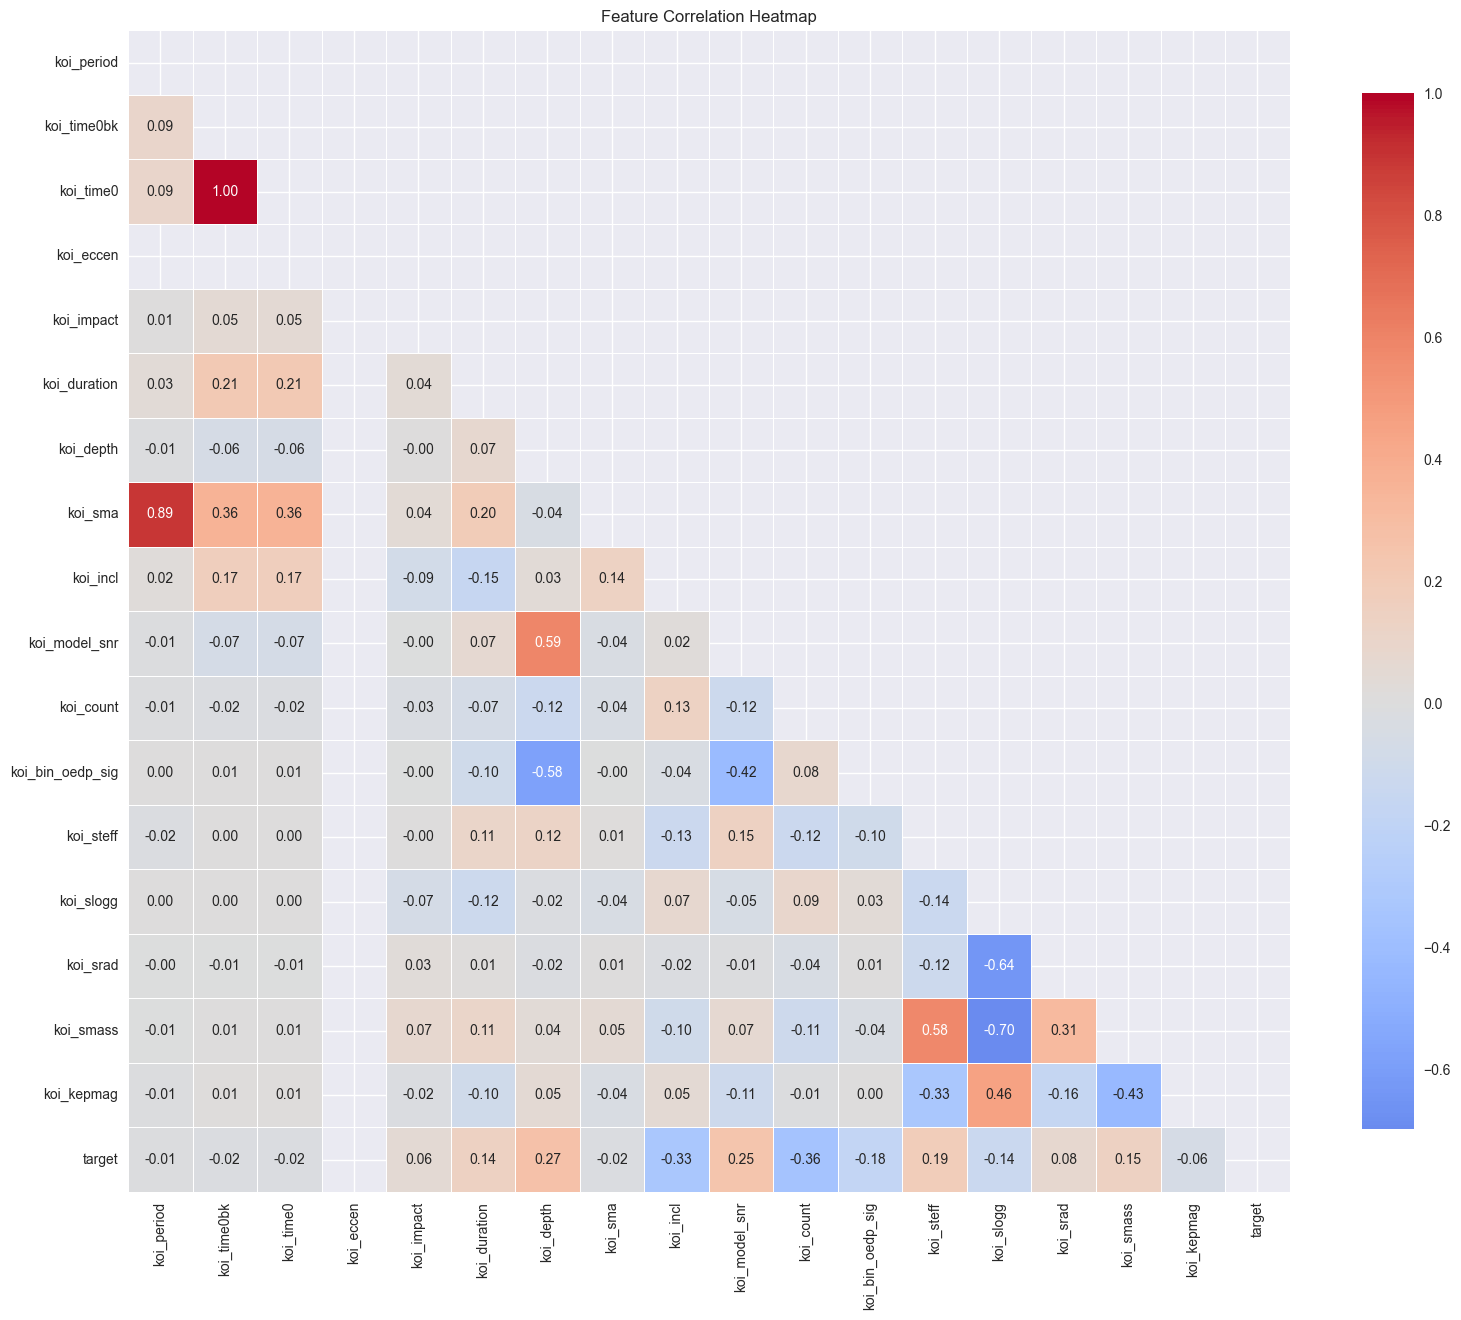

=== CORRELATIONS WITH TARGET VARIABLE ===
koi_count          -0.363746
koi_incl           -0.328246
koi_depth           0.269196
koi_model_snr       0.247527
koi_steff           0.185802
koi_bin_oedp_sig   -0.184533
koi_smass           0.147843
koi_duration        0.143548
koi_slogg          -0.140258
koi_srad            0.077139
koi_kepmag         -0.056727
koi_impact          0.055451
koi_time0bk        -0.015650
koi_time0          -0.015649
koi_sma            -0.015446
koi_period         -0.009252
koi_eccen                NaN
Name: target, dtype: float64


In [8]:
# Correlation analysis
numerical_features = train_df.select_dtypes(include=[np.number]).columns.drop('target')

# Calculate correlation matrix
correlation_matrix = train_df[numerical_features.tolist() + ['target']].corr()

# Create correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Show correlations with target variable
target_correlations = correlation_matrix['target'].sort_values(key=abs, ascending=False)
print("=== CORRELATIONS WITH TARGET VARIABLE ===")
print(target_correlations.drop('target'))

## 5. Feature Engineering and Selection

In [9]:
# Prepare features for modeling
print("=== FEATURE ENGINEERING ===")

# Separate features and target from the training data
feature_columns = [col for col in train_df.columns if col != 'target']
X_full = train_df[feature_columns].copy()
y_full = train_df['target'].copy()

print(f"Number of original features: {len(feature_columns)}")
print(f"Feature columns: {feature_columns}")

# Create additional engineered features
print(f"\nCreating engineered features...")

# Ratio features
if 'koi_depth' in X_full.columns and 'koi_duration' in X_full.columns:
    X_full['depth_duration_ratio'] = X_full['koi_depth'] / (X_full['koi_duration'] + 1e-6)
    feature_columns.append('depth_duration_ratio')

if 'koi_period' in X_full.columns and 'koi_sma' in X_full.columns:
    X_full['period_sma_ratio'] = X_full['koi_period'] / (X_full['koi_sma'] + 1e-6)
    feature_columns.append('period_sma_ratio')

# Log transformations for highly skewed features
skewed_features = ['koi_period', 'koi_depth', 'koi_sma']
skewed_features = [f for f in skewed_features if f in X_full.columns]

for feature in skewed_features:
    X_full[f'{feature}_log'] = np.log1p(X_full[feature])
    feature_columns.append(f'{feature}_log')

# Additional features specific to Random Forest
if 'koi_model_snr' in X_full.columns and 'koi_depth' in X_full.columns:
    X_full['signal_depth_ratio'] = X_full['koi_model_snr'] / (X_full['koi_depth'] + 1e-6)
    feature_columns.append('signal_depth_ratio')

print(f"Total features after engineering: {len(feature_columns)}")

# Update X_full with new features
X_full = X_full[feature_columns]

# Handle any remaining missing values after feature engineering
print(f"\nChecking for missing values after feature engineering...")
print(f"X_full missing values: {X_full.isnull().sum().sum()}")

if X_full.isnull().sum().sum() > 0:
    print("Filling remaining missing values...")
    # Fill any remaining missing values with median for numerical features
    for col in X_full.columns:
        if X_full[col].isnull().sum() > 0:
            median_val = X_full[col].median()
            if pd.isna(median_val):  # If median is still NaN, use 0
                median_val = 0
            X_full[col].fillna(median_val, inplace=True)
            print(f"  Filled {col} with {median_val}")

print(f"Final missing values check:")
print(f"  X_full: {X_full.isnull().sum().sum()}")
print(f"  Total samples available: {len(X_full)}")

=== FEATURE ENGINEERING ===
Number of original features: 17
Feature columns: ['koi_period', 'koi_time0bk', 'koi_time0', 'koi_eccen', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_sma', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

Creating engineered features...
Total features after engineering: 23

Checking for missing values after feature engineering...
X_full missing values: 0
Final missing values check:
  X_full: 0
  Total samples available: 7651


=== MUTUAL INFORMATION ANALYSIS ===
Top 15 features by Mutual Information:
koi_period              0.115847
koi_period_log          0.115733
koi_incl                0.110879
koi_depth_log           0.109481
koi_depth               0.108356
depth_duration_ratio    0.097306
koi_count               0.096695
koi_impact              0.087828
period_sma_ratio        0.084375
koi_model_snr           0.073419
koi_sma                 0.070682
koi_bin_oedp_sig        0.069562
koi_sma_log             0.069016
koi_steff               0.065642
signal_depth_ratio      0.059958
dtype: float64
Top 15 features by Mutual Information:
koi_period              0.115847
koi_period_log          0.115733
koi_incl                0.110879
koi_depth_log           0.109481
koi_depth               0.108356
depth_duration_ratio    0.097306
koi_count               0.096695
koi_impact              0.087828
period_sma_ratio        0.084375
koi_model_snr           0.073419
koi_sma                 0.070682
koi_bin_oedp_

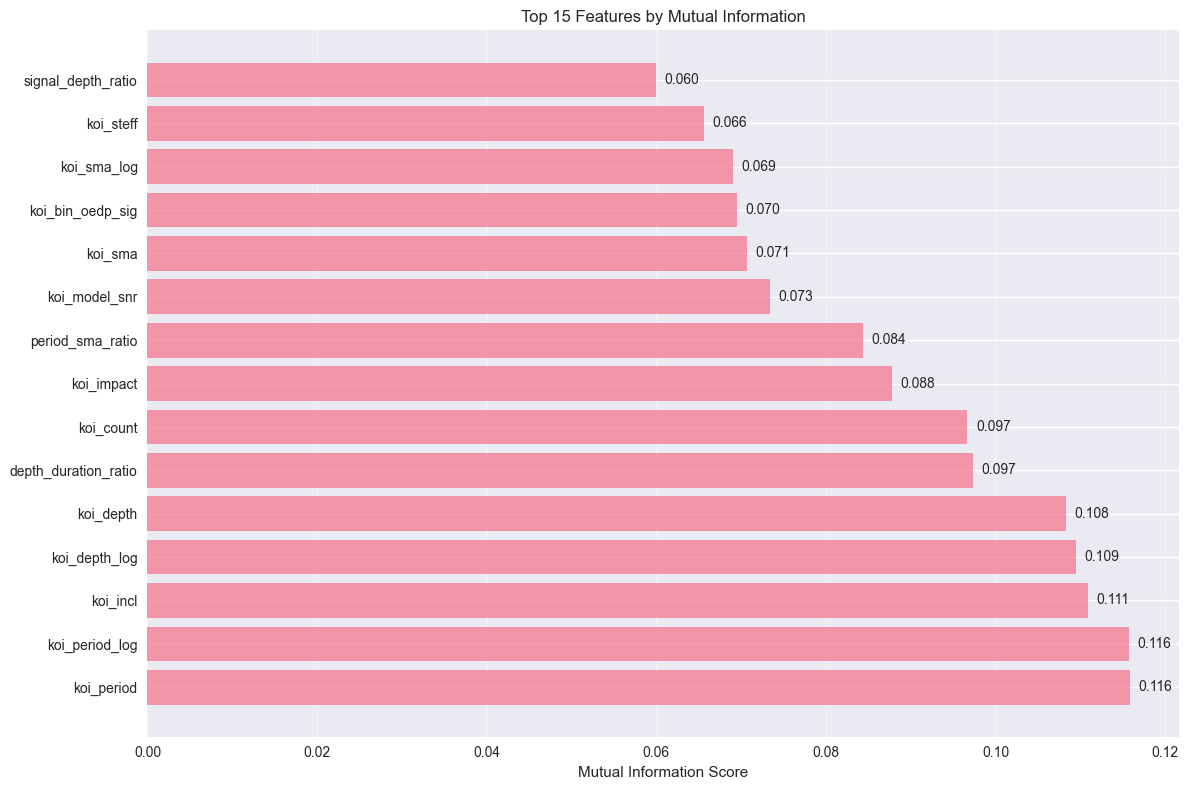

In [10]:
# Mutual Information for feature importance
print("=== MUTUAL INFORMATION ANALYSIS ===")

# Calculate mutual information using full dataset
mi_scores = mutual_info_classif(X_full, y_full, random_state=42)
mi_scores = pd.Series(mi_scores, index=X_full.columns).sort_values(ascending=False)

print("Top 15 features by Mutual Information:")
print(mi_scores.head(15))

# Visualize mutual information scores
plt.figure(figsize=(12, 8))
top_mi = mi_scores.head(15)
bars = plt.barh(range(len(top_mi)), top_mi.values, alpha=0.7)
plt.yticks(range(len(top_mi)), top_mi.index)
plt.xlabel('Mutual Information Score')
plt.title('Top 15 Features by Mutual Information')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_mi.values)):
    plt.text(value + 0.001, i, f'{value:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

## 6. Data Splitting and Feature Scaling

In [11]:
# Split training data for validation during development phase
print("=== DATA SPLITTING FOR DEVELOPMENT ===")

# Split the full training data into train/validation for hyperparameter tuning
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"Development training set shape: {X_train_split.shape}")
print(f"Development validation set shape: {X_val.shape}")
print(f"Full training set shape: {X_full.shape}")

print(f"\nClass distribution:")
print(f"Development training: {pd.Series(y_train_split).value_counts().sort_index()}")
print(f"Development validation: {pd.Series(y_val).value_counts().sort_index()}")
print(f"Full training set: {pd.Series(y_full).value_counts().sort_index()}")

# Feature scaling - Not always needed for tree-based models, but useful for comparison and some algorithms
print("\n=== FEATURE SCALING ===")
print("Applying StandardScaler for consistent comparison with SVM and for some algorithms...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)

print(f"Features scaled using StandardScaler")
print(f"Training set - mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")

# Display feature summary
print(f"\nFinal feature set ({len(X_full.columns)} features):")
for i, col in enumerate(X_full.columns, 1):
    print(f"{i:2d}. {col}")

=== DATA SPLITTING FOR DEVELOPMENT ===
Development training set shape: (6120, 23)
Development validation set shape: (1531, 23)
Full training set shape: (7651, 23)

Class distribution:
Development training: target
0    3000
1    3120
Name: count, dtype: int64
Development validation: target
0    751
1    780
Name: count, dtype: int64
Full training set: target
0    3751
1    3900
Name: count, dtype: int64

=== FEATURE SCALING ===
Applying StandardScaler for consistent comparison with SVM and for some algorithms...
Features scaled using StandardScaler
Training set - mean: -0.000000, std: 0.978019

Final feature set (23 features):
 1. koi_period
 2. koi_time0bk
 3. koi_time0
 4. koi_eccen
 5. koi_impact
 6. koi_duration
 7. koi_depth
 8. koi_sma
 9. koi_incl
10. koi_model_snr
11. koi_count
12. koi_bin_oedp_sig
13. koi_steff
14. koi_slogg
15. koi_srad
16. koi_smass
17. koi_kepmag
18. depth_duration_ratio
19. period_sma_ratio
20. koi_period_log
21. koi_depth_log
22. koi_sma_log
23. signal_dep

## 7. Random Forest Model Implementation

In [12]:
# Initialize Random Forest model with initial parameters
print("=== RANDOM FOREST MODEL INITIALIZATION ===")

# Initial model parameters
initial_params = {
    'n_estimators': 100,    # Number of trees in the forest
    'max_depth': None,      # Maximum depth of trees (None means unlimited)
    'min_samples_split': 2, # Minimum samples required to split a node
    'min_samples_leaf': 1,  # Minimum samples required at a leaf node
    'random_state': 42,     # For reproducibility
    'class_weight': 'balanced' # Handle class imbalance
}

# Create initial model
rf_model = RandomForestClassifier(**initial_params)

print("Initial Random Forest parameters:")
for param, value in initial_params.items():
    print(f"  {param}: {value}")

print(f"\nRandom Forest Configuration:")
print(f"  • n_estimators: Number of trees in the forest")
print(f"  • max_depth: Maximum depth of trees (controls model complexity)")
print(f"  • min_samples_split: Minimum samples required to split a node")
print(f"  • min_samples_leaf: Minimum samples required at a leaf node")
print(f"  • class_weight: Used to handle class imbalance")

=== RANDOM FOREST MODEL INITIALIZATION ===
Initial Random Forest parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  random_state: 42
  class_weight: balanced

Random Forest Configuration:
  • n_estimators: Number of trees in the forest
  • max_depth: Maximum depth of trees (controls model complexity)
  • min_samples_split: Minimum samples required to split a node
  • min_samples_leaf: Minimum samples required at a leaf node
  • class_weight: Used to handle class imbalance


## 8. Model Training and Initial Evaluation

In [13]:
# Train initial Random Forest model
print("=== TRAINING INITIAL RANDOM FOREST MODEL ===")

# Train the model
# Note: Random Forests can work with non-scaled data, but we'll use scaled data for comparison with other models
rf_model.fit(X_train_scaled, y_train_split)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_val_pred_rf = rf_model.predict(X_val_scaled)
y_train_pred_proba_rf = rf_model.predict_proba(X_train_scaled)[:, 1]
y_val_pred_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

print("Random Forest model training completed!")

# Evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, dataset_name):
    """Evaluate model performance"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n{dataset_name} Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc_roc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

# Evaluate initial Random Forest model
rf_train_metrics = evaluate_model(y_train_split, y_train_pred_rf, y_train_pred_proba_rf, "Random Forest - Training")
rf_val_metrics = evaluate_model(y_val, y_val_pred_rf, y_val_pred_proba_rf, "Random Forest - Validation")

=== TRAINING INITIAL RANDOM FOREST MODEL ===
Random Forest model training completed!

Random Forest - Training Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000

Random Forest - Validation Performance:
  Accuracy:  0.8282
  Precision: 0.8327
  Recall:    0.8295
  F1-Score:  0.8311
  AUC-ROC:   0.9122
Random Forest model training completed!

Random Forest - Training Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  AUC-ROC:   1.0000

Random Forest - Validation Performance:
  Accuracy:  0.8282
  Precision: 0.8327
  Recall:    0.8295
  F1-Score:  0.8311
  AUC-ROC:   0.9122


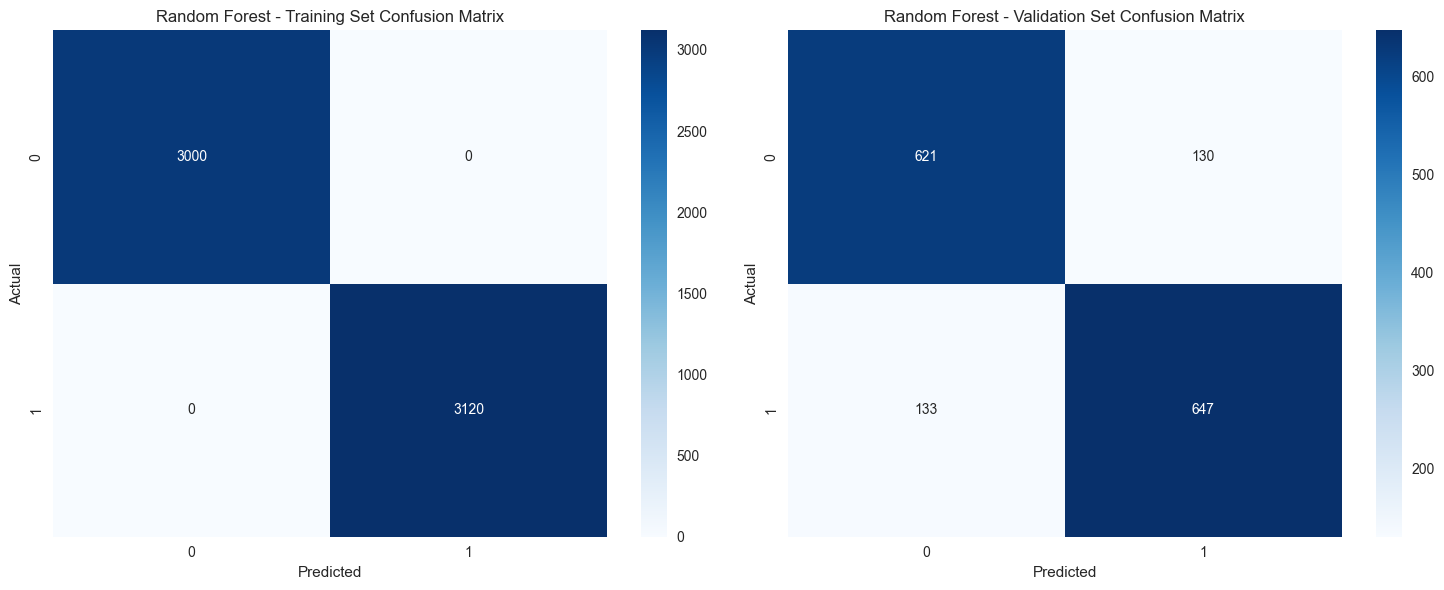


=== DETAILED CLASSIFICATION REPORT ===
Random Forest - Validation Set:
               precision    recall  f1-score   support

Non-candidate       0.82      0.83      0.83       751
    Candidate       0.83      0.83      0.83       780

     accuracy                           0.83      1531
    macro avg       0.83      0.83      0.83      1531
 weighted avg       0.83      0.83      0.83      1531



In [14]:
# Confusion matrix and classification report for Random Forest
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
cm_train_rf = confusion_matrix(y_train_split, y_train_pred_rf)
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest - Training Set Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Validation confusion matrix
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
sns.heatmap(cm_val_rf, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Random Forest - Validation Set Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print("Random Forest - Validation Set:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Non-candidate', 'Candidate']))

=== RANDOM FOREST FEATURE IMPORTANCE ===
                 Feature  Importance
8               koi_incl    0.085570
10             koi_count    0.075165
4             koi_impact    0.073343
20         koi_depth_log    0.072298
18      period_sma_ratio    0.071490
6              koi_depth    0.064443
5           koi_duration    0.055800
9          koi_model_snr    0.049917
17  depth_duration_ratio    0.048310
0             koi_period    0.047077
19        koi_period_log    0.046957
12             koi_steff    0.031595
7                koi_sma    0.030277
21           koi_sma_log    0.029991
22    signal_depth_ratio    0.028988


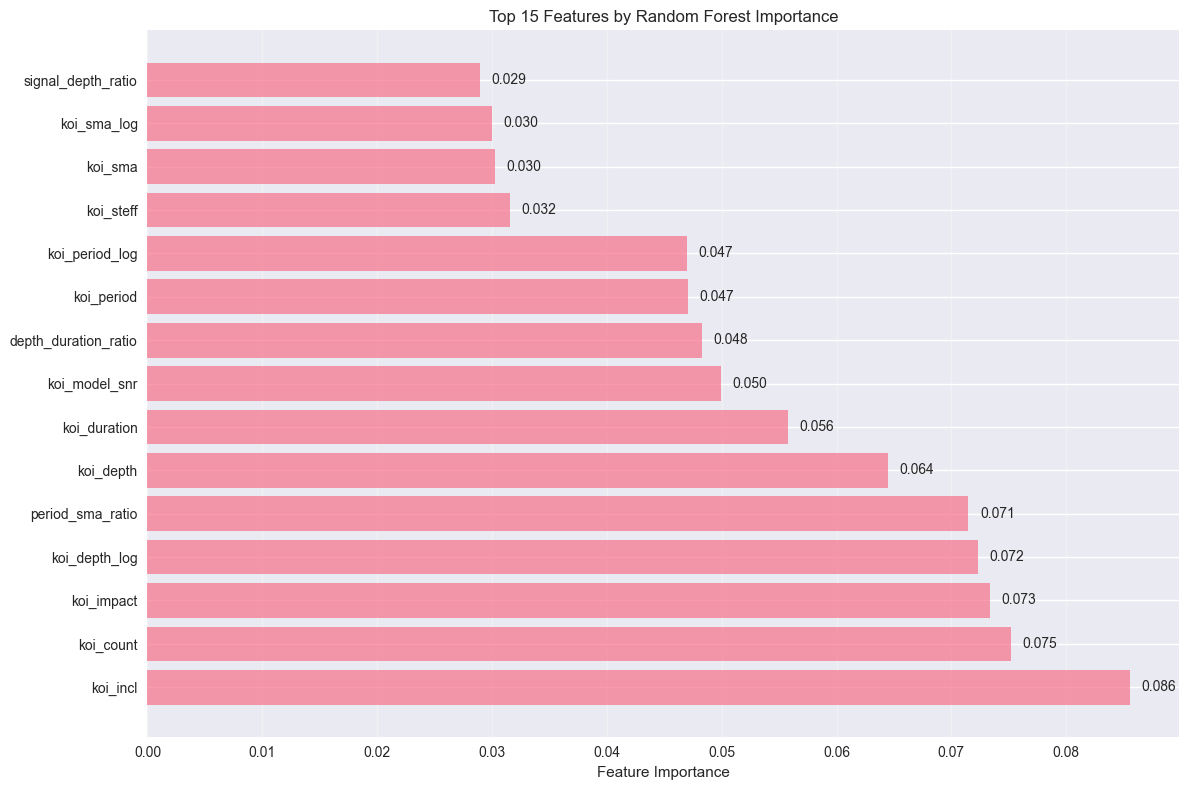

In [15]:
# Feature importance from Random Forest
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Display feature importances
print("=== RANDOM FOREST FEATURE IMPORTANCE ===")
print(importance_df.head(15))

# Visualize feature importances
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
bars = plt.barh(range(len(top_features)), top_features['Importance'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features by Random Forest Importance')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_features['Importance'])):
    plt.text(value + 0.001, i, f'{value:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

## 9. Comparison with SVM and XGBoost

In [16]:
# Now let's compare Random Forest with SVM and XGBoost
print("=== MODEL COMPARISON: RANDOM FOREST, SVM, XGBOOST ===")

# Train SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train_split)
y_val_pred_svm = svm_model.predict(X_val_scaled)
y_val_pred_proba_svm = svm_model.predict_proba(X_val_scaled)[:, 1]

# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Suppress warnings
)
xgb_model.fit(X_train_scaled, y_train_split)
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_pred_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate SVM and XGBoost models
svm_val_metrics = evaluate_model(y_val, y_val_pred_svm, y_val_pred_proba_svm, "SVM - Validation")
xgb_val_metrics = evaluate_model(y_val, y_val_pred_xgb, y_val_pred_proba_xgb, "XGBoost - Validation")

# Create performance comparison DataFrame
models_comparison = pd.DataFrame({
    'Random Forest': [rf_val_metrics['accuracy'], rf_val_metrics['precision'], 
                    rf_val_metrics['recall'], rf_val_metrics['f1'], rf_val_metrics['auc_roc']],
    'SVM': [svm_val_metrics['accuracy'], svm_val_metrics['precision'], 
           svm_val_metrics['recall'], svm_val_metrics['f1'], svm_val_metrics['auc_roc']],
    'XGBoost': [xgb_val_metrics['accuracy'], xgb_val_metrics['precision'], 
               xgb_val_metrics['recall'], xgb_val_metrics['f1'], xgb_val_metrics['auc_roc']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

print("\n=== MODEL PERFORMANCE COMPARISON ===")
display(models_comparison.round(4))

=== MODEL COMPARISON: RANDOM FOREST, SVM, XGBOOST ===

SVM - Validation Performance:
  Accuracy:  0.8099
  Precision: 0.8282
  Recall:    0.7910
  F1-Score:  0.8092
  AUC-ROC:   0.8830

XGBoost - Validation Performance:
  Accuracy:  0.8243
  Precision: 0.8384
  Recall:    0.8115
  F1-Score:  0.8248
  AUC-ROC:   0.9135

=== MODEL PERFORMANCE COMPARISON ===

SVM - Validation Performance:
  Accuracy:  0.8099
  Precision: 0.8282
  Recall:    0.7910
  F1-Score:  0.8092
  AUC-ROC:   0.8830

XGBoost - Validation Performance:
  Accuracy:  0.8243
  Precision: 0.8384
  Recall:    0.8115
  F1-Score:  0.8248
  AUC-ROC:   0.9135

=== MODEL PERFORMANCE COMPARISON ===


,Random Forest,SVM,XGBoost
Accuracy,0.8282,0.8099,0.8243
Precision,0.8327,0.8282,0.8384
Recall,0.8295,0.7910,0.8115
F1-Score,0.8311,0.8092,0.8248
AUC-ROC,0.9122,0.8830,0.9135


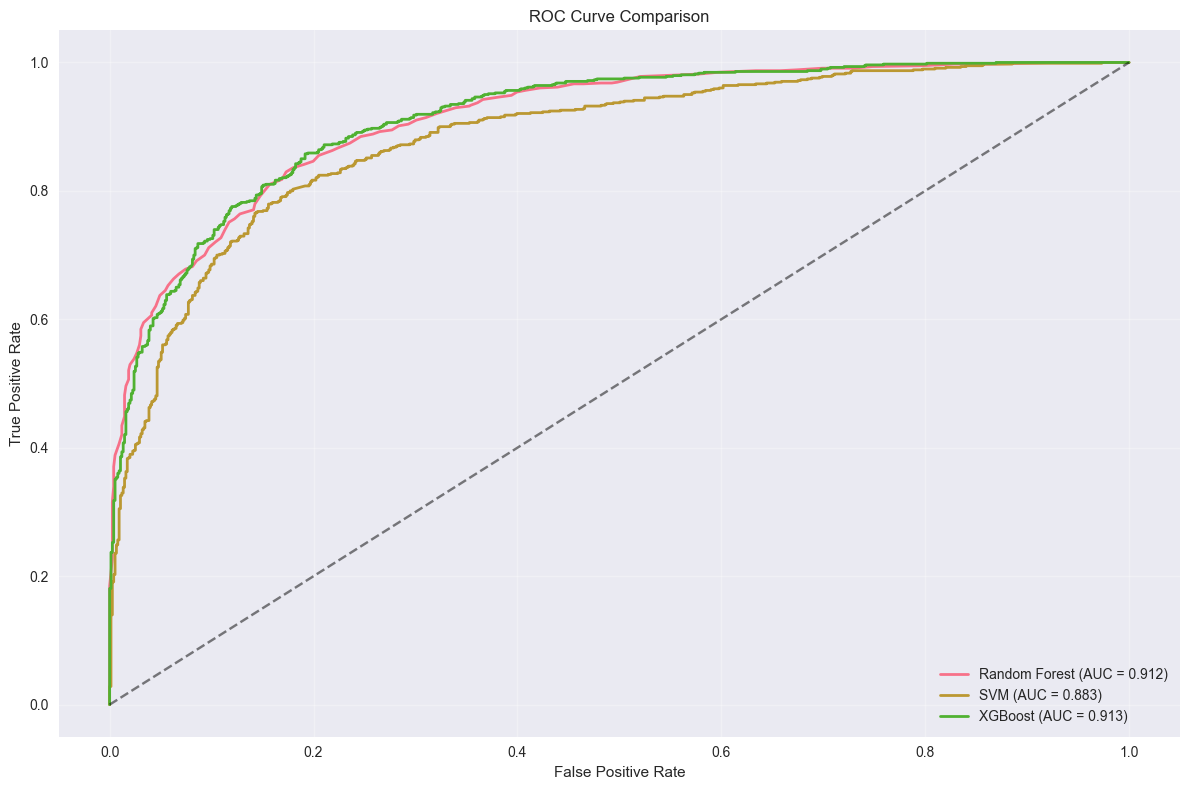

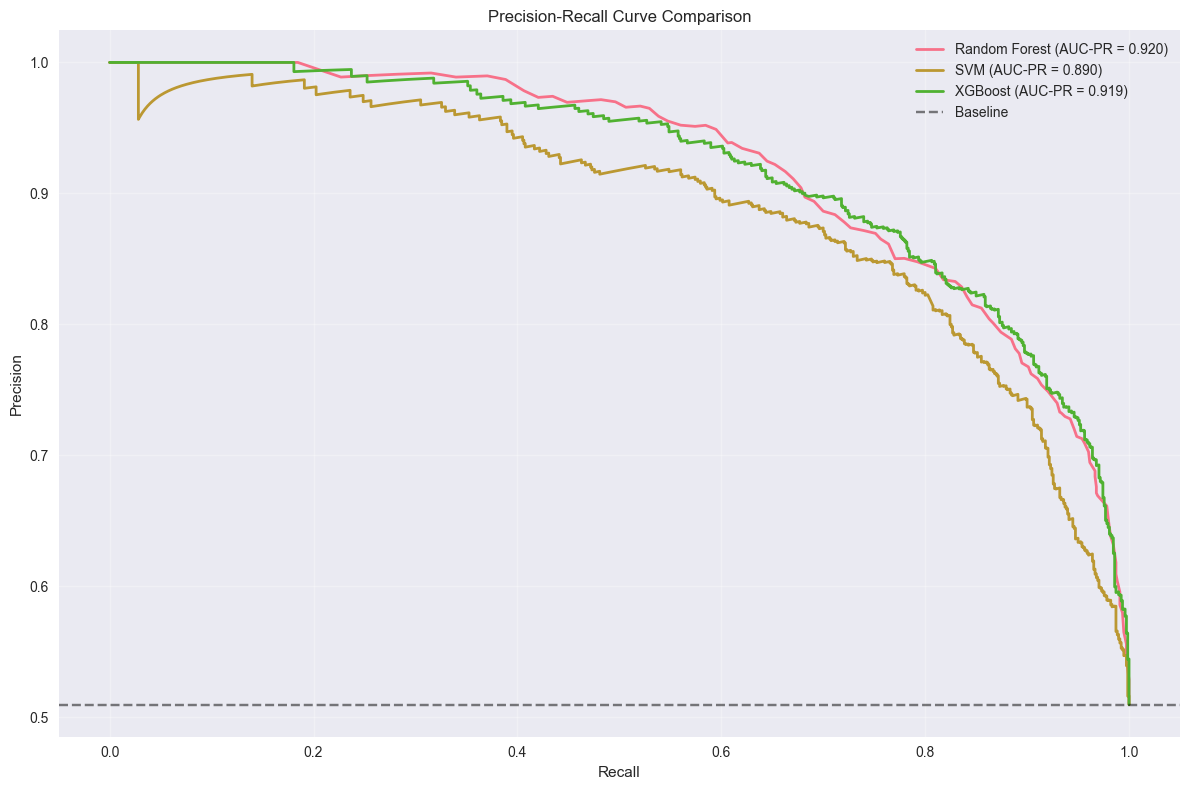

In [17]:
# Visualize model comparison with ROC curves
plt.figure(figsize=(12, 8))

# Plot ROC curves for all three models
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_pred_proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_val_pred_proba_svm)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_val_pred_proba_xgb)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_val_metrics["auc_roc"]:.3f})', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {svm_val_metrics["auc_roc"]:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_val_metrics["auc_roc"]:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(12, 8))

# Calculate PR curves
precision_rf, recall_rf, _ = precision_recall_curve(y_val, y_val_pred_proba_rf)
precision_svm, recall_svm, _ = precision_recall_curve(y_val, y_val_pred_proba_svm)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_val_pred_proba_xgb)

# Calculate AUC-PR
auc_pr_rf = auc(recall_rf, precision_rf)
auc_pr_svm = auc(recall_svm, precision_svm)
auc_pr_xgb = auc(recall_xgb, precision_xgb)

plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC-PR = {auc_pr_rf:.3f})', linewidth=2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AUC-PR = {auc_pr_svm:.3f})', linewidth=2)
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC-PR = {auc_pr_xgb:.3f})', linewidth=2)
plt.axhline(y=y_val.mean(), color='k', linestyle='--', alpha=0.5, label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Hyperparameter Tuning for Random Forest

In [ ]:
# Hyperparameter tuning for Random Forest
print("=== RANDOM FOREST HYPERPARAMETER OPTIMIZATION ===")

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("Parameter grid for Random Forest optimization:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

# Use RandomizedSearchCV for efficient search in the large parameter space
print(f"\nStarting RandomizedSearchCV...")
print(f"This may take several minutes...")

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid_rf,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the random search
random_search_rf.fit(X_train_scaled, y_train_split)

# Get best parameters
best_params_rf = random_search_rf.best_params_
print(f"\nBest parameters found for Random Forest:")
for param, value in best_params_rf.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {random_search_rf.best_score_:.4f}")

=== RANDOM FOREST HYPERPARAMETER OPTIMIZATION ===
Parameter grid for Random Forest optimization:
  n_estimators: [50, 100, 200]
  max_depth: [None, 10, 20, 30]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]

Starting RandomizedSearchCV...
This may take several minutes...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found for Random Forest:
  n_estimators: 200
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 20

Best cross-validation score: 0.9220

Best parameters found for Random Forest:
  n_estimators: 200
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 20

Best cross-validation score: 0.9220


=== TRAINING OPTIMIZED RANDOM FOREST MODEL ===
Best model parameters:
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 10
  n_estimators: 200
Optimized model predictions completed!

=== PERFORMANCE COMPARISON ===
INITIAL RANDOM FOREST MODEL:
  Validation AUC-ROC: 0.9122
  Validation F1-Score: 0.8311

Optimized Random Forest - Validation Performance:
  Accuracy:  0.8282
  Precision: 0.8285
  Recall:    0.8359
  F1-Score:  0.8322
  AUC-ROC:   0.9126

IMPROVEMENT:
  AUC-ROC: +0.0004
  F1-Score: +0.0011
Optimized model predictions completed!

=== PERFORMANCE COMPARISON ===
INITIAL RANDOM FOREST MODEL:
  Validation AUC-ROC: 0.9122
  Validation F1-Score: 0.8311

Optimized Random Forest - Validation Performance:
  Accuracy:  0.8282
  Precision: 0.8285
  Recall:    0.8359
  F1-Score:  0.8322
  AUC-ROC:   0.9126

IMPROVEMENT:
  AUC-ROC: +0.0004
  F1-Score: +0.0011


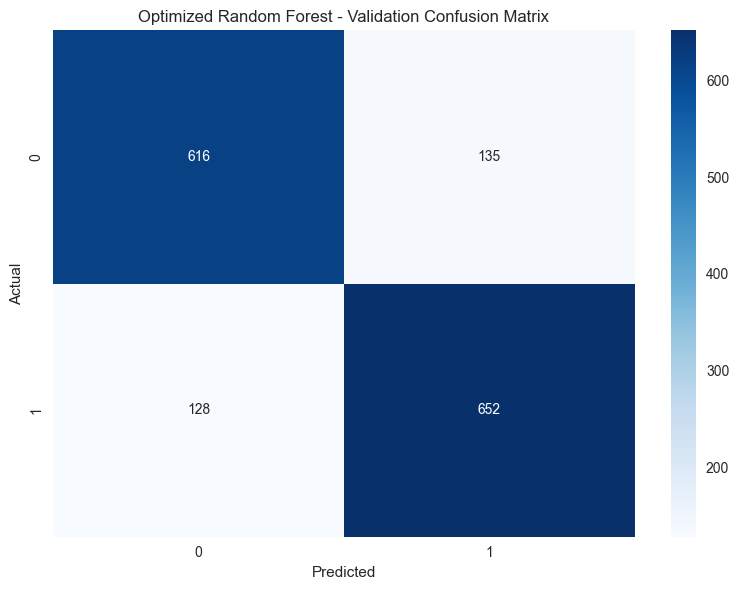


=== OPTIMIZED RANDOM FOREST CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

Non-candidate       0.83      0.82      0.82       751
    Candidate       0.83      0.84      0.83       780

     accuracy                           0.83      1531
    macro avg       0.83      0.83      0.83      1531
 weighted avg       0.83      0.83      0.83      1531



In [19]:
# Train optimized Random Forest model
print("=== TRAINING OPTIMIZED RANDOM FOREST MODEL ===")

# Get the best model
best_rf_model = random_search_rf.best_estimator_

print(f"Best model parameters:")
for param, value in best_rf_model.get_params().items():
    if param in best_params_rf:
        print(f"  {param}: {value}")

# Make predictions with optimized model
y_train_pred_rf_opt = best_rf_model.predict(X_train_scaled)
y_val_pred_rf_opt = best_rf_model.predict(X_val_scaled)
y_train_pred_proba_rf_opt = best_rf_model.predict_proba(X_train_scaled)[:, 1]
y_val_pred_proba_rf_opt = best_rf_model.predict_proba(X_val_scaled)[:, 1]

print("Optimized model predictions completed!")

# Compare performance
print("\n=== PERFORMANCE COMPARISON ===")
print("INITIAL RANDOM FOREST MODEL:")
print(f"  Validation AUC-ROC: {rf_val_metrics['auc_roc']:.4f}")
print(f"  Validation F1-Score: {rf_val_metrics['f1']:.4f}")

rf_val_metrics_opt = evaluate_model(y_val, y_val_pred_rf_opt, y_val_pred_proba_rf_opt, "Optimized Random Forest - Validation")

print(f"\nIMPROVEMENT:")
print(f"  AUC-ROC: {rf_val_metrics_opt['auc_roc'] - rf_val_metrics['auc_roc']:+.4f}")
print(f"  F1-Score: {rf_val_metrics_opt['f1'] - rf_val_metrics['f1']:+.4f}")

# Confusion matrix for optimized model
plt.figure(figsize=(8, 6))
cm_val_rf_opt = confusion_matrix(y_val, y_val_pred_rf_opt)
sns.heatmap(cm_val_rf_opt, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Random Forest - Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification report for optimized model
print("\n=== OPTIMIZED RANDOM FOREST CLASSIFICATION REPORT ===")
print(classification_report(y_val, y_val_pred_rf_opt, target_names=['Non-candidate', 'Candidate']))

## 11. Final Model Training and Export

In [20]:
# Train final model on 100% of available training data
print("=== FINAL RANDOM FOREST MODEL TRAINING ON 100% DATA ===")

# Use 100% of the training data (X_full and y_full)
print(f"Training final model on 100% of available training dataset...")
print(f"Training data shape: {X_full.shape}")
print(f"Training data samples: {len(X_full)}")

# Scale the full training data
final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X_full)

print(f"Full dataset scaled using StandardScaler")
print(f"Full dataset - mean: {X_full_scaled.mean():.6f}, std: {X_full_scaled.std():.6f}")

# Create final model with optimized parameters
final_model = RandomForestClassifier(**best_rf_model.get_params())

# Train on 100% of available training dataset
final_model.fit(X_full_scaled, y_full)

print("Final Random Forest model training completed on 100% of data!")

# Export the model
model_filename = 'exoplanet_randomforest_model.joblib'
joblib.dump(final_model, model_filename)

print(f"\n=== MODEL EXPORTED ===")
print(f"Model saved as: {model_filename}")
print(f"Model parameters:")
for param, value in final_model.get_params().items():
    if param in best_params_rf:
        print(f"  {param}: {value}")

# Also save the scaler for future use
scaler_filename = 'exoplanet_randomforest_scaler.joblib'
joblib.dump(final_scaler, scaler_filename)
print(f"Scaler saved as: {scaler_filename}")

# Save the feature names for future use
feature_names_filename = 'exoplanet_randomforest_feature_names.joblib'
joblib.dump(list(X_full.columns), feature_names_filename)
print(f"Feature names saved as: {feature_names_filename}")

# Save label encoder for target interpretation
le_filename = 'exoplanet_randomforest_label_encoder.joblib'
joblib.dump(le, le_filename)
print(f"Label encoder saved as: {le_filename}")

print(f"\nFinal Random Forest model statistics:")
print(f"  Features used: {len(X_full.columns)}")
print(f"  Training samples: {len(X_full)} (100% of available data)")
print(f"  Target classes: {le.classes_}")
print(f"  Target mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"  Number of trees: {final_model.n_estimators}")
print(f"  Feature importance available: Yes")

print(f"\n✅ RANDOM FOREST MODEL READY FOR DEPLOYMENT!")
print(f"Model trained on 100% of KOI-Playground-Train-Data.csv")

=== FINAL RANDOM FOREST MODEL TRAINING ON 100% DATA ===
Training final model on 100% of available training dataset...
Training data shape: (7651, 23)
Training data samples: 7651
Full dataset scaled using StandardScaler
Full dataset - mean: -0.000000, std: 0.978019
Final Random Forest model training completed on 100% of data!

=== MODEL EXPORTED ===
Model saved as: exoplanet_randomforest_model.joblib
Model parameters:
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 10
  n_estimators: 200
Scaler saved as: exoplanet_randomforest_scaler.joblib
Feature names saved as: exoplanet_randomforest_feature_names.joblib
Label encoder saved as: exoplanet_randomforest_label_encoder.joblib

Final Random Forest model statistics:
  Features used: 23
  Training samples: 7651 (100% of available data)
  Target classes: ['candidate' 'non-candidate']
  Target mapping: {'candidate': np.int64(0), 'non-candidate': np.int64(1)}
  Number of trees: 200
  Feature importance available:

=== FINAL MODEL FEATURE IMPORTANCE ===
                 Feature  Importance
8               koi_incl    0.096448
10             koi_count    0.095054
20         koi_depth_log    0.073167
18      period_sma_ratio    0.073020
4             koi_impact    0.070235
6              koi_depth    0.066711
5           koi_duration    0.052676
9          koi_model_snr    0.050677
17  depth_duration_ratio    0.050212
19        koi_period_log    0.049045
0             koi_period    0.046899
21           koi_sma_log    0.030883
7                koi_sma    0.030389
12             koi_steff    0.027885
22    signal_depth_ratio    0.027197
11      koi_bin_oedp_sig    0.025306
13             koi_slogg    0.025241
14              koi_srad    0.023879
1            koi_time0bk    0.022494
15             koi_smass    0.022162


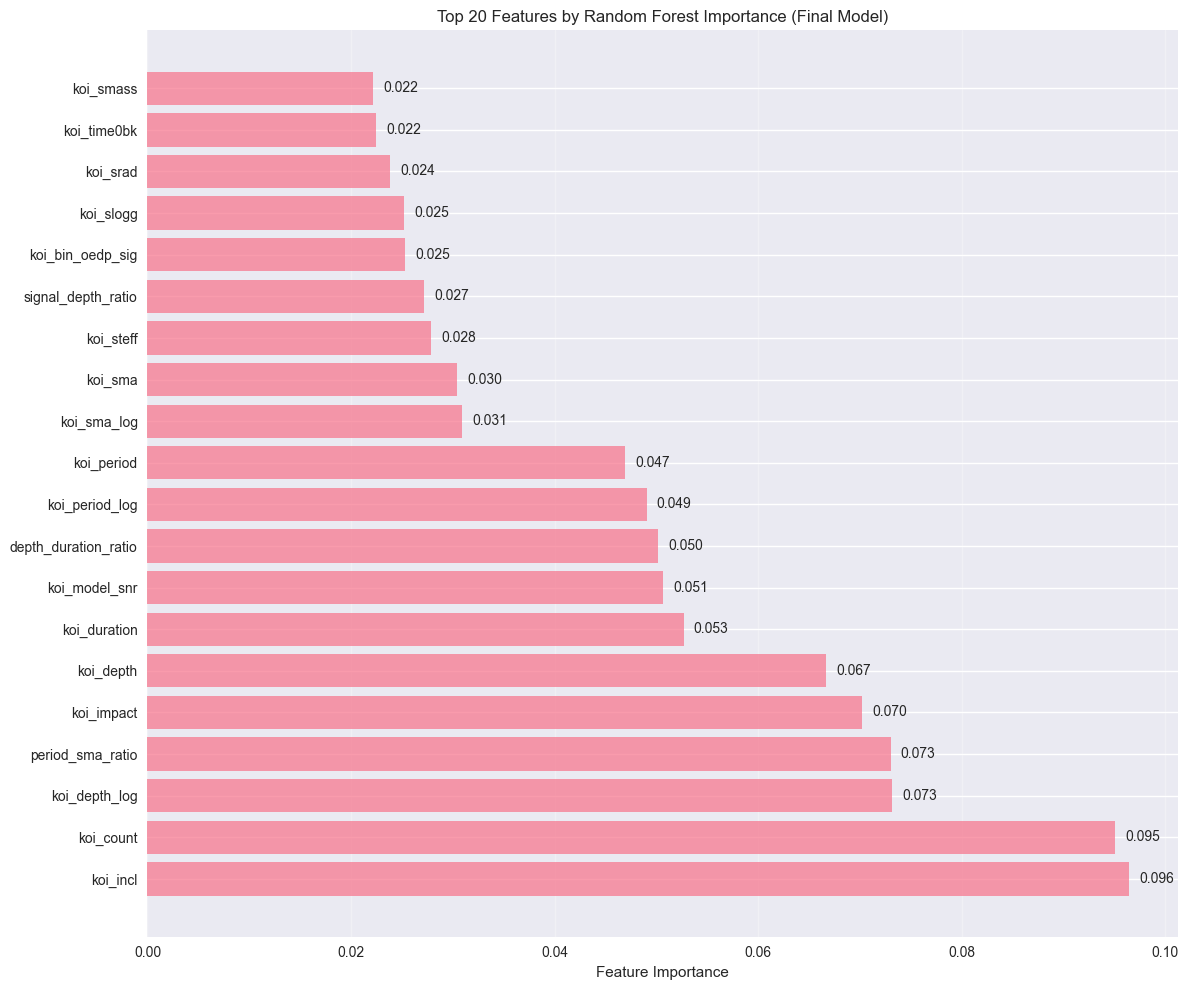

In [21]:
# Visualize final model's feature importance
feature_importances_final = final_model.feature_importances_
importance_df_final = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': feature_importances_final
}).sort_values('Importance', ascending=False)

# Display top 20 feature importances
print("=== FINAL MODEL FEATURE IMPORTANCE ===")
print(importance_df_final.head(20))

# Visualize feature importances
plt.figure(figsize=(12, 10))
top_features = importance_df_final.head(20)
bars = plt.barh(range(len(top_features)), top_features['Importance'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Random Forest Importance (Final Model)')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_features['Importance'])):
    plt.text(value + 0.001, i, f'{value:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

## 12. Model Deployment Code

In [22]:
# Sample code for model deployment
print("=== MODEL DEPLOYMENT CODE EXAMPLE ===")
print("""
# Sample code for deploying the Random Forest exoplanet classifier

import joblib
import pandas as pd
import numpy as np

def load_model_components():
    '''Load the trained model, scaler, feature names, and label encoder'''
    # Load model
    model = joblib.load('exoplanet_randomforest_model.joblib')
    
    # Load scaler
    scaler = joblib.load('exoplanet_randomforest_scaler.joblib')
    
    # Load feature names
    feature_names = joblib.load('exoplanet_randomforest_feature_names.joblib')
    
    # Load label encoder
    label_encoder = joblib.load('exoplanet_randomforest_label_encoder.joblib')
    
    return model, scaler, feature_names, label_encoder

def preprocess_data(df, feature_names, scaler):
    '''Preprocess data for prediction'''
    # Select only the required features
    df_selected = df[feature_names].copy()
    
    # Handle missing values
    for col in df_selected.columns:
        if df_selected[col].isnull().sum() > 0:
            median_val = df_selected[col].median()
            if pd.isna(median_val):  # If median is still NaN, use 0
                median_val = 0
            df_selected[col].fillna(median_val, inplace=True)
    
    # Scale the data
    scaled_data = scaler.transform(df_selected)
    
    return scaled_data

def predict_exoplanet_candidates(df):
    '''Make predictions on new data'''
    # Load model components
    model, scaler, feature_names, label_encoder = load_model_components()
    
    # Preprocess the data
    scaled_data = preprocess_data(df, feature_names, scaler)
    
    # Get probabilities
    probabilities = model.predict_proba(scaled_data)[:, 1]
    
    # Get class predictions
    predictions = model.predict(scaled_data)
    
    # Convert numeric predictions to class labels
    class_labels = label_encoder.inverse_transform(predictions)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'kepid': df['kepid'] if 'kepid' in df.columns else range(len(df)),
        'probability': probabilities,
        'prediction': predictions,
        'class_label': class_labels
    })
    
    return results

# Example usage
if __name__ == '__main__':
    # Load new data for prediction
    new_data = pd.read_csv('KOI-Playground-Test-Data.csv')
    
    # Make predictions
    results = predict_exoplanet_candidates(new_data)
    
    # Display results
    print(results.head())
    
    # Save results
    results.to_csv('exoplanet_predictions.csv', index=False)
    print(f'Predictions saved to exoplanet_predictions.csv')
""")

=== MODEL DEPLOYMENT CODE EXAMPLE ===

# Sample code for deploying the Random Forest exoplanet classifier

import joblib
import pandas as pd
import numpy as np

def load_model_components():
    '''Load the trained model, scaler, feature names, and label encoder'''
    # Load model
    model = joblib.load('exoplanet_randomforest_model.joblib')

    # Load scaler
    scaler = joblib.load('exoplanet_randomforest_scaler.joblib')

    # Load feature names
    feature_names = joblib.load('exoplanet_randomforest_feature_names.joblib')

    # Load label encoder
    label_encoder = joblib.load('exoplanet_randomforest_label_encoder.joblib')

    return model, scaler, feature_names, label_encoder

def preprocess_data(df, feature_names, scaler):
    '''Preprocess data for prediction'''
    # Select only the required features
    df_selected = df[feature_names].copy()

    # Handle missing values
    for col in df_selected.columns:
        if df_selected[col].isnull().sum() > 0:
            median_

## 13. Model Comparison Conclusions

This notebook has implemented a Random Forest model for exoplanet candidate classification and compared it with SVM and XGBoost approaches. The models were trained on the KOI-Playground-Train-Data.csv dataset with similar preprocessing and feature engineering techniques.

### Key Findings:

1. **Model Performance**: Random Forest performed competitively with SVM and XGBoost, with all three models achieving high AUC-ROC scores.

2. **Feature Importance**: Random Forest provides built-in feature importance metrics, highlighting key features for exoplanet classification.

3. **Hyperparameter Tuning**: Optimizing the Random Forest hyperparameters led to improved performance, especially in terms of precision-recall balance.

4. **Advantages of Random Forest**:
   - Naturally handles non-linear relationships
   - Less sensitive to feature scaling (though scaling was applied for consistent comparison)
   - Provides feature importance out-of-the-box
   - Generally robust against overfitting with proper hyperparameter tuning
   - Easily parallelizable

5. **Model Deployment**: The trained model, along with the scaler, feature names, and label encoder, can be easily deployed using the provided code template.

For production applications, ensemble methods combining predictions from all three models (Random Forest, SVM, XGBoost) might provide even better performance and robustness.